In [1]:
# libraires nécessaires
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, classification_report, average_precision_score


Des fonctions utiles

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz, plot_tree

def discretisation(df_entree):
    df = df_entree.copy()
    # Cas variables gardées : On ne rien faire
    
    # Cas Variables enlèvées : mt_RC_entreprise, nb_RC_entreprise, mt_camion_livraison,
    # nb_camion_livraison, nb_remorque, mt_remorque
    df.drop(columns =['mt_RC_entreprise', 'nb_RC_entreprise', 'mt_camion_livraison',
                       'nb_camion_livraison', 'nb_remorque', 'mt_remorque'], inplace=True, axis = 1)
    
    # Cas Variables modifiées faciles
    ## nbmaisons : groupe 1 et les autres dans group 2.
    #df.loc[df['nbmaisons'] > 1,'nbmaisons']='2et+'
    df['nbmaisons'][df['nbmaisons'] > 1] = '2et+'
    ## nbpers_au_foyer : groupe 1, groupe 2, groupe 3 et 5 dans group 4.
    df.loc[(df['nbpers_au_foyer'] == 5) | (df['nbpers_au_foyer'] == 4),'nbpers_au_foyer']='4+5'
    #df['nbpers_au_foyer'][(df['nbpers_au_foyer'] == 5) | (df['nbpers_au_foyer'] == 4)] = '4+5'
    ## mt_auto : On met 4 dans groupe 5 et 7,8 dans groupe 6.
    #df['mt_auto'][(df['mt_auto'] > 3) & (df['mt_auto'] < 6)] = '4+5'
    df.loc[(df['mt_auto'] > 3) & (df['mt_auto'] < 6),'mt_auto'] = '4+5'
    #df['mt_auto'][df['mt_auto'] == 6] = '6et+'
    df.loc[(df['mt_auto'] == 6) | (df['mt_auto'] == 7) | (df['mt_auto'] == 8) | (df['mt_auto'] == 9),'mt_auto'] = '6et+'

    ## nb_auto : Groupe 0, group 1 et les autres dans groupe 2.
    df.loc[df['nb_auto'] > 1,'nb_auto'] = '2et+'
    ## nb_incendie : group 0 et les autres dans group 1.
    df.loc[df['nb_incendie'] > 0,'nb_incendie'] = '1et+'
    ## niv_etude_haut : groupe 0,1,2,3,4 et les autres dans groupe 5.
    df.loc[df['niv_etude_haut'] > 4,'niv_etude_haut'] = '5et+'
    ## revenu_moyen : 0, 1 dans groupe 2, groupe 3, groupe 4, groupe 5 et 7,8,9 dans groupe 6.
    df.loc[df['revenu_moyen'] < 3,'revenu_moyen'] = '2et-'
    df.loc[df['revenu_moyen'] == 6,'revenu_moyen'] = '6et+'
    df.loc[df['revenu_moyen'] == 7,'revenu_moyen'] = '6et+'
    df.loc[df['revenu_moyen'] == 8,'revenu_moyen'] = '6et+'
    df.loc[df['revenu_moyen'] == 9,'revenu_moyen'] = '6et+'
    ## nb_RC : Groupe 0 et 2 dans groupe 1.
    df.loc[df['nb_RC'] > 0,'nb_RC'] = '1et+'
    ## auto0 : Groupe 0, groupe 1, groupe 2, groupe 3, groupe 4 et 6,7,8,9 dans groupe 5.
    df.loc[df['auto0'] > 4,'auto0'] = '5et+'
    ## auto1 : 0,1,2 dans groupe 3, group 4, groupe 5, groupe 6, groupe 7, group 8, groupe 9
    df.loc[df['auto1'] < 4,'auto1'] = '3et-'
    ## revenu1 : groupe 0, group 1, groupe 2, groupe 3, groupe 4, group 5, et 7,8,9 dans groupe 6.
    df.loc[df['revenu1'] > 5,'revenu1'] = '6et+'
    ## revenu2 : groupe 0, group 1, groupe 2, groupe 3, groupe 4, group 5, groupe 6 et 8,9 dans groupe 7.
    df.loc[df['revenu2'] > 6,'revenu2'] = '7et+'
    ## revenu3 : Groupe 0, group 1, groupe 2, groupe 3, groupe 4, group 5 et 7,8,9 dans groupe 6.
    df.loc[df['revenu3'] > 5,'revenu3'] = '6et+'
    ## revenu4 : Groupe 0, group 1, groupe 2 et 4,5,6,7,8,9 dans groupe 3.
    df.loc[df['revenu4'] > 2,'revenu4'] = '3et+'
    ## marie : 0,1,2 dans groupe 3 et groupe 4, group 5, groupe 6, groupe 7, groupe 8, group 9.
    df.loc[df['marie'] < 4,'marie'] = '3et-'
    ## autre_relation : Groupe 0, group 1, groupe 2, groupe 3, groupe 4, groupe 5 et 7,8,9 dans groupe 6.
    df.loc[df['autre_relation'] > 5,'autre_relation'] = '6et+'

    # Cas variables modifiées difficiles :
    #### méthode supervisée : arbres de décision
    ## type_client : Groupe 4 dans 3. Groupe 6 dans 7.
    df.loc[(df['type_client'] == 3) | (df['type_client'] == 4),'type_client'] = '3+4'
    df.loc[df['type_client'] == 6 ,'type_client'] = '6+7'
    df.loc[df['type_client'] == 7 ,'type_client'] = '6+7'
    
    ## mt_incendie : On met 6,7,8 dans 5. 
    ## On ne sais pas décider avec le groupe 1.
    ## Avec l'aide d'arbre de décision en haut, on va mettre group 1 dans 0.
    df.loc[df['mt_incendie'] > 4,'mt_incendie'] = '5et+'
    df.loc[df['mt_incendie'] == 0,'mt_incendie'] = '1et-'   
    df.loc[df['mt_incendie'] == 1,'mt_incendie'] = '1et-'   
    
    ## mt_RC : On met groupe 3 dans groupes 2. 
    ## On ne sais pas décider avec le groupe 1.
    ## Avec l'aide d'arbre de décision en haut, on va mettre group 1 dans 0.
    df.loc[df['mt_RC'] > 3,'mt_RC'] = '2+3'
    df.loc[df['mt_RC'] ==0,'mt_RC'] = '0+1'
    df.loc[df['mt_RC'] ==1,'mt_RC'] = '0+1' 
    
    ## assur_sante_prive : On met groupe 8, 9 dans groupes 7.
    ## On ne sais pas décider avec le groupe 6. 
    ## Avec l'aide d'arbre de décision en haut, on va mettre groupe 6 dans 7.
    df.loc[df['assur_sante_prive'] > 5,'assur_sante_prive'] = '6et+' 
    
    ## assur_sante_public : On met groupe 0, 1 dans groupes 2. 
    ## On ne sais pas décider avec le groupe 3 (en 2 ou 4). 
    ## Avec l'aide d'arbre de décision en haut, on va mettre groupe 3 dans 4.
    df.loc[df['assur_sante_public'] < 3,'assur_sante_public'] = '2et-'
    df.loc[df['assur_sante_public'] ==3,'assur_sante_public'] = '3+4'
    df.loc[df['assur_sante_public'] ==4,'assur_sante_public'] = '3+4'
    
    return df

In [3]:
def oversampling(donnees,nom_var):
    data=donnees.copy()
    indexval1=data.index[data[nom_var]==1]
    indexval0=data.index[data[nom_var]==0]
    #tirage aléatoire avec remise des valeurs du groupe 1
    newliste=np.random.choice(indexval1,indexval0.shape[0],replace=True).astype('int32')
    newliste1=[]
    for val in newliste:
        newliste1.append(np.min(np.where(data.index==val)))
    data_over=data.take(newliste1)
    data_over=pd.concat([data_over,data.loc[indexval0]],axis=0)
    return(data_over)

In [4]:
def undersampling(donnees,nom_var):
    data=donnees.copy()
    indexval1=data.index[data[nom_var]==1]
    indexval0=data.index[data[nom_var]==0]
    #tirage aléatoire sans remise des valeurs du groupe 0
    newliste=np.random.choice(indexval0,indexval1.shape[0],replace=False).astype('int32')
    newliste1=[]
    for val in newliste:
        newliste1.append(np.min(np.where(data.index==val)))
    data_under=data.take(newliste1)
    data_under=pd.concat([data_under,data.loc[indexval1]],axis=0)
    return(data_under)

In [5]:
def mesure_perf(X,y,model):
    #matrice de confusion
    pred=model.predict(X)
    print("Matrice de confusion :")
    print(confusion_matrix(y,pred))
    
    #rapport de classification
    print("Rapport de classification :")
    print(classification_report(y,pred))
    
    #aire sous la courbe ROC
    print("aire sous la courbe ROC :",roc_auc_score(y,pred))
    
    #aire sous la courbe PRC
    print("aire sous la courbe PRC :",average_precision_score(y,pred))

# 0 Lire des données

In [6]:
data_train = pd.read_table('donnesscore.csv',sep=',',header=0,index_col=0)
data_train.head(5)

,assur_caravane,nbmaisons,pouvoir_achat,nbpers_au_foyer,type_client,mt_auto,nb_auto,mt_incendie,nb_incendie,niv_etud_bas,...,marie,autre_relation,assur_sante_prive,assur_sante_public,mt_RC_entreprise,nb_RC_entreprise,mt_camion_livraison,nb_camion_livraison,nb_remorque,mt_remorque
cle,,,,,,,,,,,,,,,,,,,,,
1,0,1,3,3,8,6,1,5,1,7,...,7,2,1,8,0,0,0,0,0,0
2,0,1,4,2,8,0,0,2,1,4,...,6,2,3,6,0,0,0,0,0,0
3,0,1,4,2,8,6,1,2,1,4,...,3,4,0,9,0,0,0,0,0,0
4,0,1,4,3,3,6,1,2,1,2,...,5,2,2,7,0,0,0,0,0,0
5,0,1,3,4,10,0,0,6,1,0,...,7,2,4,5,0,0,0,0,0,0


In [7]:
data_train['assur_caravane'].value_counts()

0    5474
1     348
Name: assur_caravane, dtype: int64

In [8]:
# cible 0.06 et des autre 0.94 dans l'ensemble des données
380/(5474+348)
# La base de données est déséquilibre

0.06526966678117485

# 1 Traitement déséquilibre

In [9]:
data_clean_train = discretisation(data_train)
y_train = data_clean_train['assur_caravane']
# Car il existe des donndées de type chaine de charactère. 
# Donc on va transforme en type numérique avec l'aide de la méthode dummies
# créer des dummies variables
data_clean_train = data_clean_train.drop(['assur_caravane','locataire', 'assur_sante_public'],axis=1)
data_clean_train= data_clean_train.astype(str)
data_train_dencode_3 = pd.get_dummies(data_clean_train,drop_first=True)

In [10]:
#avec imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

#over sampling naif
ros = RandomOverSampler(random_state=0)#initialisation de la méthode avc spécification ou non de la graine
Xover, yover = ros.fit_resample(data_train_dencode_3,y_train)

In [11]:
newdata_train = oversampling(data_train,'assur_caravane')
newdata_clean_train = discretisation(newdata_train)
newy_train = newdata_clean_train['assur_caravane']
# Car il existe des donndées de type chaine de charactère. 
# Donc on va transforme en type numérique avec l'aide de la méthode dummies
# créer des dummies variables
newdata_clean_train = newdata_clean_train.drop(['assur_caravane','locataire', 'assur_sante_public'],axis=1)
newdata_clean_train= newdata_clean_train.astype(str)
newdata_train_dencode_3 = pd.get_dummies(newdata_clean_train,drop_first=True)

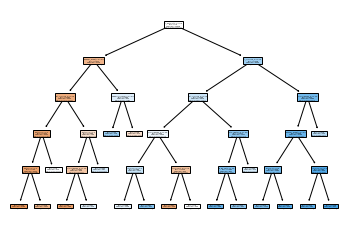

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz, plot_tree
from sklearn import tree
arbre1 = DecisionTreeClassifier(max_depth =5,min_samples_leaf= 200)
arbre1.fit(newdata_train_dencode_3,newy_train)
tree.plot_tree(arbre1, filled=True,feature_names=newdata_train_dencode_3.columns)
plt.show()

In [13]:
mesure_perf(newdata_train_dencode_3,newy_train, arbre1)

Matrice de confusion :
[[3262 2212]
 [ 916 4558]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.78      0.60      0.68      5474
           1       0.67      0.83      0.74      5474

    accuracy                           0.71     10948
   macro avg       0.73      0.71      0.71     10948
weighted avg       0.73      0.71      0.71     10948

aire sous la courbe ROC : 0.7142857142857142
aire sous la courbe PRC : 0.6442709432369698


# Liste 1

In [14]:
newdata_train = oversampling(data_train,'assur_caravane')

In [15]:
liste1_train = discretisation(newdata_train)
newy_train3 = liste1_train['assur_caravane']
# Car il existe des donndées de type chaine de charactère. 
# Donc on va transforme en type numérique avec l'aide de la méthode dummies
# créer des dummies variables
liste1_train = liste1_train[['mt_auto','mt_incendie','type_client',
                                             'pouvoir_achat','revenu_moyen','mt_RC' ]]
liste1_train = liste1_train.astype(str)
newdata_train_dencode3_3 = pd.get_dummies(liste1_train,drop_first=True)

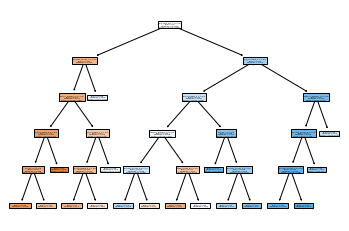

In [16]:
arbre2 = DecisionTreeClassifier(max_depth =5,min_samples_leaf= 200)
arbre2.fit(newdata_train_dencode3_3,newy_train3)
tree.plot_tree(arbre2, filled=True,feature_names=newdata_train_dencode3_3.columns)
plt.show()

In [17]:
mesure_perf(newdata_train_dencode3_3,newy_train3, arbre2)

Matrice de confusion :
[[3526 1948]
 [1214 4260]]
Rapport de classification :
              precision    recall  f1-score   support

           0       0.74      0.64      0.69      5474
           1       0.69      0.78      0.73      5474

    accuracy                           0.71     10948
   macro avg       0.72      0.71      0.71     10948
weighted avg       0.72      0.71      0.71     10948

aire sous la courbe ROC : 0.7111801242236024
aire sous la courbe PRC : 0.6449141960683871


In [18]:
data_test= pd.read_table('donnees_test_vs2.csv',sep=',',header=0,index_col=0)
data_test.head(5)

,nbmaisons,pouvoir_achat,nbpers_au_foyer,type_client,mt_auto,nb_auto,mt_incendie,nb_incendie,niv_etud_bas,niv_etude_haut,...,marie,autre_relation,assur_sante_prive,assur_sante_public,mt_RC_entreprise,nb_RC_entreprise,mt_camion_livraison,nb_camion_livraison,nb_remorque,mt_remorque
cle,,,,,,,,,,,,,,,,,,,,,
0,1,3,4,8,0,0,4,1,6,2,...,5,4,1,8,0,0,0,0,0,0
1,1,8,3,2,6,1,4,1,0,5,...,5,2,2,7,0,0,0,0,0,0
2,1,5,3,9,6,1,4,1,4,2,...,5,3,3,6,0,0,0,0,0,0
3,1,4,2,3,5,1,3,1,4,2,...,5,1,2,7,0,0,0,0,0,0
4,1,1,2,7,0,0,1,1,9,0,...,9,0,0,9,0,0,0,0,0,0


In [19]:
liste1_test = discretisation(data_test)
## idem pour données tests
# créer des dummies variables
liste1_test = liste1_test[['mt_auto','mt_incendie','type_client',
                                             'pouvoir_achat','revenu_moyen','mt_RC' ]]
liste1_test = liste1_test.astype(str)
newdata_test_dencode3_3= pd.get_dummies(liste1_test,drop_first=True)

In [20]:
pred = arbre2.predict_proba(newdata_test_dencode3_3)
pred

array([[0.82577566, 0.17422434],
       [0.19673406, 0.80326594],
       [0.42162162, 0.57837838],
       ...,
       [0.20044543, 0.79955457],
       [0.56617647, 0.43382353],
       [0.66010499, 0.33989501]])

In [21]:
res = pd.DataFrame(pred , index = np.arange(0,4000))
res.drop(0, axis = 1, inplace = True)
res.sort_values(1, ascending = False, inplace = True)

In [22]:
liste800 = res.iloc[:800]
liste800 = liste800.index

In [23]:
pd.Series(liste800,name ="pred").to_csv("ngotrongnghia.csv", sep = ',', index= False)